# Initialization

In [52]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from timeit import default_timer as timer


import tensorflow.compat.v1.keras.backend as K
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

from keras.utils.np_utils import to_categorical
from tensorflow.keras.models import Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, AvgPool2D, BatchNormalization, Reshape
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler
from keras.applications.resnet import preprocess_input

#XAI modules
import keras
from matplotlib.colors import LinearSegmentedColormap
import shap
import json

shap.initjs()

# Motivation

Data Science practitioners will know that there exists a typical model interpretability vs. model performance trade-off. A point to remember here is that model performance is not the run-time or execution performance, but how accurate the model can be in making decisions. There are several models including simple linear models or even tree-based models, which can easily explain the decisions taken by the model to arrive at a particular insight or prediction, but you might need to sacrifice model performance since they always do not yield the best results due to inherent problems of high bias (linear models) or high variance, leading to overfitting (fully grown tree models). More complex models like ensemble models and the more recent deep learning family of models often yield better performance, but are perceived as black-box models, because it is extremely difficult to explain how the model might be really making its decisions under the hood.

There are a lot of real-world scenarios where biased models might have really adverse effects. This includes predicting potential criminals, judicial sentencing risk scores, credit scoring, fraud detection, health assessment, loan lending, self-driving and many more where model understanding and interpretation is of utmost importance. The same is highlighted by renowned Data Scientist and Author Cathy O’ Neil in her acclaimed book, ‘Weapons of Math Destruction’.

Interested readers should also definitely check out her famous article on the NY Times, ‘Artificial Intelligence’s White Guy Problem’ where she shows us examples of machine learning applications including image categorization, criminal risk predictions, delivery service availability and many more were biased and yielded unfavorable outcomes for the black community. All these real-world scenarios are implications of how important model interpretation should be, and if we want to leverage machine learning to solve these problems.

[NY times White Guy Problem](https://www.nytimes.com/2016/06/26/opinion/sunday/artificial-intelligences-white-guy-problem.html)

# Understanding Machine Learning Model Interpretation

The key to model interpretation is transparency, the ability to question, and the ease of understanding model decisions by humans. The three most important aspects of model interpretation are explained as follows.

1. What drives model predictions? We should have the ability to query our model and find out latent feature interactions to get an idea of which features might be important in the decision-making policies of the model. This ensures **fairness** of the model.

2. Why did the model take a certain decision? We should also be able to validate and justify why certain key features were responsible in driving certain decisions taken by a model during predictions. This ensures **accountability** and reliability of the model.

3. How can we trust model predictions? We should be able to evaluate and validate any data point and how a model takes decisions on it. This should be demonstrable and easy to understand for key stakeholders that the model works as expected. This ensures **transparency** of the model.

# CNNs explained

CNNs typically consist of multiple convolution and pooling layers which help the deep learning model in automatically extracting relevant features from visual data like images. Due to this multi-layered architecture, CNNs learn a robust hierarchy of features, which are spatial, rotation, and translation invariant.

 ![Source: becominghuman.ai ](./images/CNN_01.gif)

The key operations in a CNN model are depicted in the figure above. Any image can be represented as a tensor of pixel values. The convolution layers help in extracting features from this image (forms feature maps). Shallower layers (closer to the input data) in the network learn very generic features like edges, corners and so on. Deeper layers in the network (closer to the output layer) learn very specific features pertaining to the input image. The following graphic helps summarize the key aspects of any CNN model.

 ![ ](./images/CNN_02.png)


Here’s the interesting part, can we really unbox the opacity presented to us by a seemingly black-box CNN model and try and understand what’s really going on under the hood and what does the model really see when it looks at an image? There are a wide variety of techniques and tools for interpreting decisions made by vision-based deep learning models. Some of the major techniques covered in notebook are depicted as follows.

 ![ ](./images/SHAD_01.png)

Let’s look at each of these techniques and interpret some deep learning CNN-based models built with Keras and TensorFlow.

## SHAP Gradient Explainer

This technique tries to explain model decisions using expected gradients (an extension of integrated gradients). This is a feature attribution method designed for differentiable models based on an extension of Shapley values to infinite player games.

Integrated gradients values are a bit different from SHAP values, and require a single reference value to integrate from. However in SHAP Gradient Explainer, expected gradients reformulates the integral as an expectation and combines that expectation with sampling reference values from the background dataset. Thus this technique uses an entire dataset as the background distribution versus just a single reference value. Let’s try and implement this on some sample images. To get started, we load up some basic dependencies and model visualization function utilities.

In [53]:
# utility function to visualize SHAP values in larger image formats
# this modifies the `shap.image_plot(...)` function
def visualize_model_decisions(shap_values, x, labels=None, figsize=(20, 30)):
    
    colors = []
    for l in np.linspace(1, 0, 100):
        colors.append((30./255, 136./255, 229./255,l))
    for l in np.linspace(0, 1, 100):
        colors.append((255./255, 13./255, 87./255,l))
    red_transparent_blue = LinearSegmentedColormap.from_list("red_transparent_blue", colors)

    multi_output = True
    if type(shap_values) != list:
        multi_output = False
        shap_values = [shap_values]

    # make sure labels
    if labels is not None:
        assert labels.shape[0] == shap_values[0].shape[0], "Labels must have same row count as shap_values arrays!"
        if multi_output:
            assert labels.shape[1] == len(shap_values), "Labels must have a column for each output in shap_values!"
        else:
            assert len(labels.shape) == 1, "Labels must be a vector for single output shap_values."

    # plot our explanations
    fig_size = figsize
    fig, axes = plt.subplots(nrows=x.shape[0], ncols=len(shap_values) + 1, figsize=fig_size)
    if len(axes.shape) == 1:
        axes = axes.reshape(1,axes.size)
    for row in range(x.shape[0]):
        x_curr = x[row].copy()

        # make sure
        if len(x_curr.shape) == 3 and x_curr.shape[2] == 1:
            x_curr = x_curr.reshape(x_curr.shape[:2])
        if x_curr.max() > 1:
            x_curr /= 255.
        
        axes[row,0].imshow(x_curr)
        axes[row,0].axis('off')
        
        # get a grayscale version of the image
        if len(x_curr.shape) == 3 and x_curr.shape[2] == 3:
            x_curr_gray = (0.2989 * x_curr[:,:,0] + 0.5870 * x_curr[:,:,1] + 0.1140 * x_curr[:,:,2]) # rgb to gray
        else:
            x_curr_gray = x_curr

        if len(shap_values[0][row].shape) == 2:
            abs_vals = np.stack([np.abs(shap_values[i]) for i in range(len(shap_values))], 0).flatten()
        else:
            abs_vals = np.stack([np.abs(shap_values[i].sum(-1)) for i in range(len(shap_values))], 0).flatten()
        max_val = np.nanpercentile(abs_vals, 99.9)
        for i in range(len(shap_values)):
            if labels is not None:
                axes[row,i+1].set_title(labels[row,i])
            sv = shap_values[i][row] if len(shap_values[i][row].shape) == 2 else shap_values[i][row].sum(-1)
            axes[row,i+1].imshow(x_curr_gray, cmap=plt.get_cmap('gray'), alpha=0.15, extent=(-1, sv.shape[0], sv.shape[1], -1))
            im = axes[row,i+1].imshow(sv, cmap=red_transparent_blue, vmin=-max_val, vmax=max_val)
            axes[row,i+1].axis('off')
        
    cb = fig.colorbar(im, ax=np.ravel(axes).tolist(), label="SHAP value", orientation="horizontal", aspect=fig_size[0]/0.2)
    cb.outline.set_visible(False)

# Loading our trained model

In [54]:
model =  keras.models.load_model('model-5x5.h5')
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        2432      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
 dense_2 (Dense)             (None, 500)               4096500   
                                                                 
 dense_3 (Dense)             (None, 43)                21543     
                                                                 
Total params: 4,120,475
Trainable params: 4,120,475
Non-trainable params: 0
____________________________________________

# Loading some images

In [55]:
# Opening file for reading in binary mode
with open('./dataset/data3.pickle', 'rb') as f:
    data = pickle.load(f, encoding='latin1')  # dictionary type


# Showing loaded data from file
for i, j in data.items():
    if i == 'labels':
        print(i + ':', len(j))
    else: 
        print(i + ':', j.shape)

labels: 43
y_validation: (4410,)
x_test: (12630, 3, 32, 32)
x_validation: (4410, 3, 32, 32)
x_train: (86989, 3, 32, 32)
y_test: (12630,)
y_train: (86989,)


(81, 32, 32, 3)


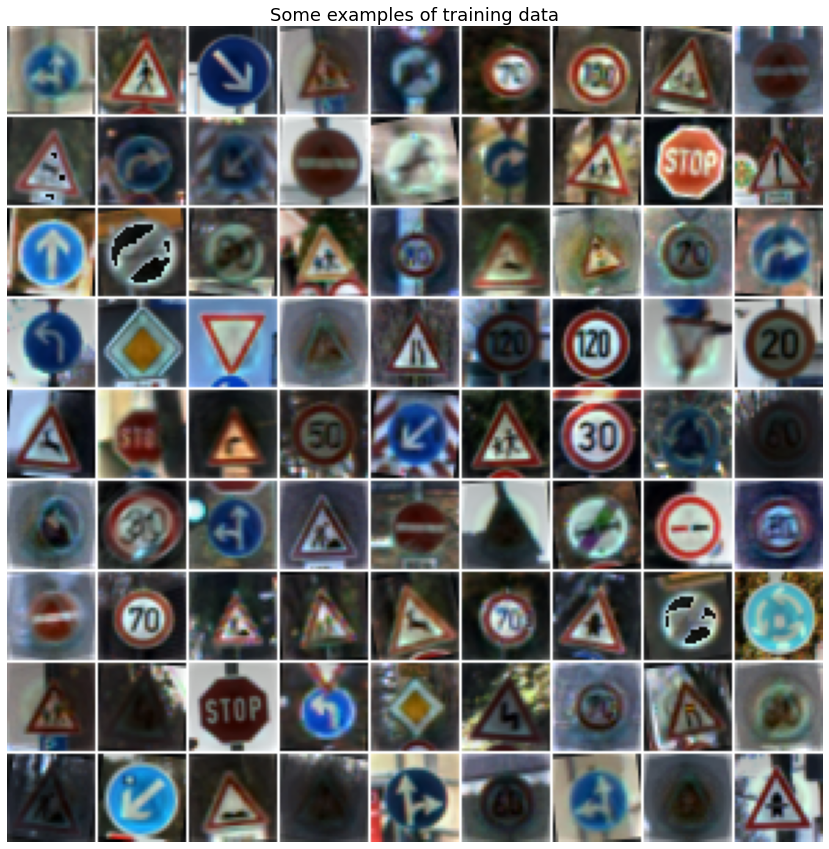

In [56]:
%matplotlib inline

# Preparing function for ploting set of examples
# As input it will take 4D tensor and convert it to the grid
# Values will be scaled to the range [0, 255]
def convert_to_grid(x_input):
    N, H, W, C = x_input.shape
    grid_size = int(np.ceil(np.sqrt(N)))
    grid_height = H * grid_size + 1 * (grid_size - 1)
    grid_width = W * grid_size + 1 * (grid_size - 1)
    grid = np.zeros((grid_height, grid_width, C)) + 255
    next_idx = 0
    y0, y1 = 0, H
    for y in range(grid_size):
        x0, x1 = 0, W
        for x in range(grid_size):
            if next_idx < N:
                img = x_input[next_idx]
                low, high = np.min(img), np.max(img)
                grid[y0:y1, x0:x1] = 255.0 * (img - low) / (high - low)
                next_idx += 1
            x0 += W + 1
            x1 += W + 1
        y0 += H + 1
        y1 += H + 1

    return grid


# Visualizing some examples of training data
examples = data['x_train'][:81, :, :, :].transpose(0, 2, 3, 1)
print(examples.shape)  # (81, 32, 32, 3)

# Plotting some examples
fig = plt.figure()
grid = convert_to_grid(examples)
plt.imshow(grid.astype('uint8'), cmap='gray')
plt.axis('off')
plt.gcf().set_size_inches(15, 15)
plt.title('Some examples of training data', fontsize=18)

# Showing the plot
plt.show()

# Saving the plot
fig.savefig('training_examples.png')
plt.close()

38 SignName    Keep right
Name: 38, dtype: object
33 SignName    Turn right ahead
Name: 33, dtype: object
6 SignName    End of speed limit (80km/h)
Name: 6, dtype: object
11 SignName    Right-of-way at the next intersection
Name: 11, dtype: object


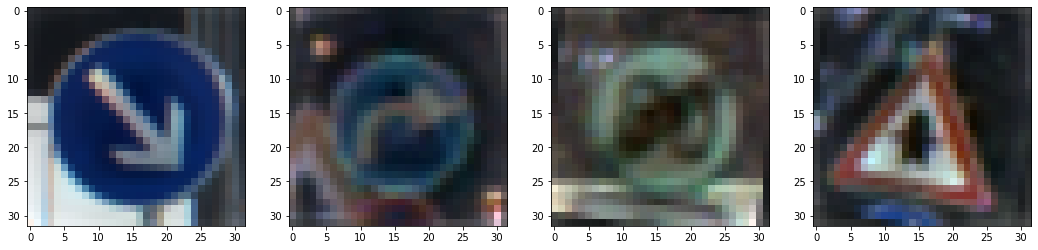

In [57]:
# Getting labels
labels = pd.read_csv('./dataset/label_names.csv', header=[0], index_col=0)
y_train = data['y_train']

def getLabel(index, labels):
    print (index, labels.iloc[index])

# picking 4 images to predict

def showImage(image):
    img = image
    low, high = np.min(img), np.max(img)
    return (img - low) / (high - low)

sample = [2, 10, 20, 60]

# get images and show them

to_predict = []
y = []
fig, ax = plt.subplots(1, 4, figsize=(18, 10))
p = int(0)

for i in sample:
    to_predict.append(examples[i])
    y.append(y_train[i])
    ax[p].imshow(showImage(to_predict[p]), cmap='gray')
    ax[p].set_title(getLabel(y[p], labels))
    p += 1

plt.show()


# Let's look at the model's prediction on these images

In [58]:
# Getting scores from forward pass of input image
scores = []
to_predict = np.array(to_predict)
to_predict.shape
scores = model.predict(to_predict)
#print(scores)


In [59]:
#Get prediction label
print (np.argmax(scores, axis=1))
predicted_labels = [str(labels['SignName'][label]) for label in np.argmax(scores, axis=1)]
print(predicted_labels)

[38 39  6 11]
['Keep right', 'Keep left', 'End of speed limit (80km/h)', 'Right-of-way at the next intersection']


## Let’s start by trying to visualize what the model sees in the 5th layer of the neural network (typically one of the shallower layers in the model).

In [60]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        2432      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
 dense_2 (Dense)             (None, 500)               4096500   
                                                                 
 dense_3 (Dense)             (None, 43)                21543     
                                                                 
Total params: 4,120,475
Trainable params: 4,120,475
Non-trainable params: 0
____________________________________________

In [61]:
import json
# how many layers do we have
print (model.layers.__len__())
# let's get more info on the individual layers
for l in model.layers:
    print ('=======' + l.name + '======')
    print (json.dumps(l.get_config(), indent=4, sort_keys=False))

5
=======conv2d_1======
{
    "name": "conv2d_1",
    "trainable": true,
    "batch_input_shape": [
        null,
        32,
        32,
        3
    ],
    "dtype": "float32",
    "filters": 32,
    "kernel_size": [
        5,
        5
    ],
    "strides": [
        1,
        1
    ],
    "padding": "same",
    "data_format": "channels_last",
    "dilation_rate": [
        1,
        1
    ],
    "groups": 1,
    "activation": "relu",
    "use_bias": true,
    "kernel_initializer": {
        "class_name": "GlorotUniform",
        "config": {
            "seed": null
        }
    },
    "bias_initializer": {
        "class_name": "Zeros",
        "config": {}
    },
    "kernel_regularizer": null,
    "bias_regularizer": null,
    "activity_regularizer": null,
    "kernel_constraint": null,
    "bias_constraint": null
}
=======max_pooling2d_1======
{
    "name": "max_pooling2d_1",
    "trainable": true,
    "dtype": "float32",
    "pool_size": [
        2,
        2
    ],
    "p

In [63]:
# utility function to pass inputs to specific model layers
def map2layer(x, layer):
    feed_dict = dict(zip([model.layers[0].input], preprocess_input(to_predict.copy())))
    print (feed_dict)
    return K.get_session().run(model.layers[layer].input, feed_dict)

In [64]:
# focus on the 5th layer of CNN model
print(model.layers[4].input)


KerasTensor(type_spec=TensorSpec(shape=(None, 500), dtype=tf.float32, name=None), name='dense_2/Relu:0', description="created by layer 'dense_2'")


In [65]:
# make model predictions
e = shap.GradientExplainer((model.layers[4].input, model.layers[-1].output), 
                            map2layer(to_predict, 4))
shap_values, indexes = e.shap_values(map2layer(to_predict, 7), ranked_outputs=2)

index_names = np.vectorize(lambda x: labels[str(x)][1])(indexes)
print(index_names)

TypeError: Tensors are unhashable (this tensor: KerasTensor(type_spec=TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name='conv2d_1_input'), name='conv2d_1_input', description="created by layer 'conv2d_1_input'")). Instead, use tensor.ref() as the key.

In [ ]:
# visualize model decisions
visualize_model_decisions(shap_values=shap_values, x=to_predict, 
                          labels=index_names, figsize=(20, 40))